In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
data = pd.read_csv("Processed.csv")
df = data[['Content','SourceatBot7']]
df = df[df['SourceatBot7'].str.contains("Human") | df['SourceatBot7'].str.contains("Bot")]

In [ ]:
df.shape
df.index = range(117940)
df['Content'].apply(lambda x: len(x.split(' '))).sum()

2826176

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


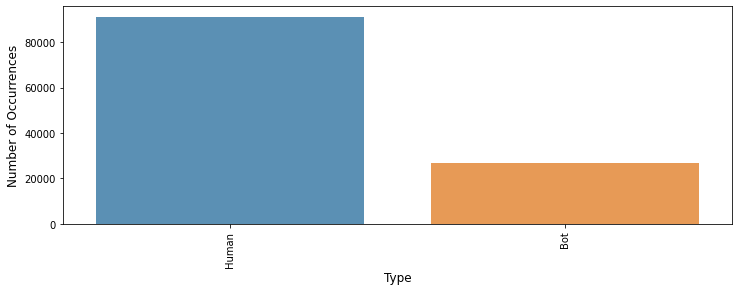

In [ ]:
cnt_pro = df['SourceatBot7'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Content'] = df['Content'].apply(cleanText)

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
train, test = train_test_split(df, test_size=0.2, random_state=1)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Content']), tags=[r.SourceatBot7]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Content']), tags=[r.SourceatBot7]), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 94352/94352 [00:00<00:00, 2343853.85it/s]


In [ ]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 94352/94352 [00:00<00:00, 2389379.45it/s]


In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print('LGR Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('LGR Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('LGR Testing CM: {}\n'.format(confusion_matrix(y_test, y_pred)))

LGR Testing accuracy 0.7728929964388672
LGR Testing F1 score: 0.6739226242173857
LGR Testing CM: [[    0  5356]
 [    1 18231]]



In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
gnb = BernoulliNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print('NB Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('NB Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('NB Testing CM: {}\n'.format(confusion_matrix(y_test, y_pred)))

NB Testing accuracy 0.7727234186874682
NB Testing F1 score: 0.6742382701470985
NB Testing CM: [[    5  5351]
 [   10 18222]]



In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print('SVM Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('SVM Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('SVM Testing CM: {}\n'.format(confusion_matrix(y_test, y_pred)))

SVM Testing accuracy 0.7729353908767169
SVM Testing F1 score: 0.6739434742450647
SVM Testing CM: [[    0  5356]
 [    0 18232]]



---